In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from textwrap import indent

from IPython.display import Javascript

from liblet import ANTLR, AnnotatedTreeWalker, Tree, pyast2tree, side_by_side

from operator import add, mul, truediv, sub

from operator import itemgetter

from IPython.display import Latex

from fractions import Fraction

import importlib

from core.arithmetic_manager import ArithManager

from core.util import *

from core.shunting_yard_parser import ShuntingYardParser
from core.arithmetic_manager import ArithManager
from core.util import *

In [12]:
Fraction(2, 4) + Fraction(3, 4)

Fraction(5, 4)

In [13]:
ex1 = '1 + {2 x [(3 + 4 : 2) + 5] x 6} - [ 7 + (1 + 8) : 3 ] x [ 9 : (2 + 1) + 2 ]'
ex2 = '< 2 + 3 > / 4 / < 5 + 6 > / 7'
ex3 = '2 ^ < 3 + 4 ^ 5 : 2 ^ 7 >'
ex4 = '3 + 13 x -<1 + 3>/<2^<1+4> - 6>'
ex5a = '3 / < 4 + 2 > + 2 x { 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > } - < 2 x [ 5 x ( 3 + 4 ) + 5 ] - 1 > / 6'
ex5b = '3 / < 4 + 2 > + 2 x ( 3 : ( 4 + 5 ) + 2 ^ < 6 x 1/2 > ) - < 2 x ( 5 x ( 3 + 4 ) + 5 ) - 1 > / 6'

src = ex5b

AM = ArithManager()
ptree = AM.ptree('antlrGrammar.g', src)
ast = AM.ptree2ast(ptree)
blocks = AM.blocks(ast)
MEMORY = dict(blocks)

#display(ast)

main_block = blocks[-1][1]
child_to_calc = None

current_block = block_id = None

while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]
    
while blocks:
    block_id, current_block = blocks[0]
        
    parent_to_calc = AM.prior(current_block)
    display_latex(AM.latex(main_block, MEMORY))

    parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                if is_next_to_calc(child) else child
                                for child in parent_to_calc.children]
    
    if is_calculable(current_block):
        current_block = current_block.children[0]
        blocks = blocks[1:]
        
    MEMORY[block_id] = current_block

display_latex(AM.latex(main_block, {}))



ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [14]:
def ast_eval(ast, show_latex, show_ast):
    AM = ArithManager()
    
    if show_ast: display(ast)
        
    blocks = AM.blocks(ast)
    MEMORY = dict(blocks)
    main_block = blocks[-1][1]
    child_to_calc = None
    current_block = block_id = None

    while blocks and is_calculable(blocks[0][1]): blocks = blocks[1:]

    while blocks:
        block_id, current_block = blocks[0]
        parent_to_calc = AM.prior(current_block)
        tex = AM.latex(main_block, MEMORY)
        if show_latex: display_latex(tex)
        
        parent_to_calc.children =  [Tree({'type': 'atomExpr', 'value': AM.eval(child, MEMORY), 'priority': 0, '_calc': 'last'}, []) 
                                    if is_next_to_calc(child) else child
                                    for child in parent_to_calc.children]

        if is_calculable(current_block):
            current_block = current_block.children[0]
            blocks = blocks[1:]

        MEMORY[block_id] = current_block

    tex = AM.latex(main_block, {})
    if show_latex: display_latex(tex)
    
    return main_block.children[0].root['value']


def antlr_eval(expr, show_latex=False, show_ast = False):
    AM = ArithManager()
    ast = AM.ptree2ast(AM.ptree('antlrGrammar.g',expr))
    return ast_eval(ast, show_latex, show_ast)


def shunting_eval(expr, show_latex=False, show_ast = False):
    AM = ArithManager()


    ast = AM.shuntingYardExpr2ast(expr)
    return ast_eval(ast, show_latex, show_ast)


In [25]:
from core.expression_generator import generate_expression

wrong_expr = []
for _ in range(150):
    exception = False
    expr = generate_expression(4)
    
    try:
        antlr_res = antlr_eval(expr)
    except Exception as e:
        exception = True

    try:
        shunting_res = shunting_eval(expr)
        if exception: 
            wrong_expr.append(expr)
            continue
    except Exception as e:
        print('** EXCEPTION SHUNTING ** ', e)
        if not exception: 
            wrong_expr.append(expr)
        continue

    formatted_expr = expr.replace('x', '*').replace(':', '/').replace('^', '**')
    res =  round(eval(formatted_expr), 3)

    if antlr_res != shunting_res or abs(antlr_res - res) > 1:
        wrong_expr.append(expr)
        
    
    #print(antlr_res, shunting_res, res)
        
if wrong_expr != []:
    print(f'*** WRONG {len(wrong_expr)} ***\n')
    for i, it in enumerate(wrong_expr):
        print(f' $$$ {i} $$$  ', it)
else:
    print("ALL DONE")

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generat

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generat

ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
** EXCEPTION SHUNTING **  can't convert complex to int
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
** EXCEPTION SHUNTING **  can't convert complex to int
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions dis

['39', '/', '--', '15', '/', '16']


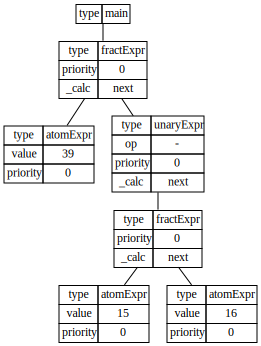

In [30]:
shunting_yard_parser = ShuntingYardParser()

ast = shunting_yard_parser.parse(expr)
ast_eval(ast, False, False)
ast

In [46]:
expr = '- ( - ( ( 60 + - 49 + 72 ^ 2 ^ -2 ) + ( 11 - - - ( 14 ) ^ -2 x 12 - ( 21 ) + ( 15 ) + - 67 ^ 2 ) ) ) x - - - - ( 17 x ( 90 ) ^ -2 / 48 x 100 + 96 ) x - ( 18 ) / ( 44 ^ -2 / 19 ^ 2 x 71 ) x 80 - 93 - - 34 / ( 3 ) / ( ( 69 x 31 + 92 ) ) - ( 20 ) / - 40 ^ -2 - - - ( - 30 / 57 ) - - - ( 96 x 6 ^ -2 )'
formatted_expr = expr.replace('x', '*').replace(':', '/').replace('^', '**')
real_expr = expr.replace('x', '*').replace(':', '/')
print(real_expr)
res =  round(eval(formatted_expr), 3)
shunt = shunting_eval(expr, False, False)
ant = antlr_eval(expr, False, False)
print(shunt, ant, res)



- ( - (1 + ( 11 - - - ( 14 ) ^ -2 * 12 - ( 21 ) + ( 15 ) + - 67 ^ 2 ) ) ) * - - - - ( 17 * ( 90 ) ^ -2 / 48 * 100 + 96 ) * - ( 18 ) / ( 44 ^ -2 / 19 ^ 2 * 71 ) * 80 - 93 - - 34 / ( 3 ) / ( ( 69 * 31 + 92 ) ) - ( 20 ) / - 40 ^ -2 - - - ( - 30 / 57 ) - - - ( 96 * 6 ^ -2 )
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
24291467244042595080163/3981725937 24291467244042595080163/3981725937 6100738129240.71


In [47]:
24291467244042595080163/3981725937

6100738129240.711

In [24]:
expr = '89 + ( - 3 + 100 ) / ( - ( 66 ) ) / - 19 x 37 - 55 / ( 20 x ( 49 x 80 ) ) / ( ( 87 ) - ( - 26 ) ) + - ( - - 88 + 72 / ( - 19 ) ^ -2 + - 31 + 8 ^ -2 ^ -2 + 15 - 89 )'
antlr_res = antlr_eval(expr)

shunting_res = shunting_eval(expr)
antlr_res, shunting_res



ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2
ANTLR runtime and generated code versions disagree: 4.9.1!=4.7.2


(-25883.73256, -25883.73256)

In [10]:
75713/2704 * -1/36 * 1/25281 * 2.806 * 515070259.31

-44465.29303204521